In [69]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import pickle as pkl
from time import time
import uuid
import zipfile

## Reading the dataset:

In [70]:
# Uncomment if you are in Google Colab:

# !pip install wget
# import wget, os
# url = "https://github.com/IvanSol/ml-course/raw/refs/heads/master/Class05_classic_CV/data/barcodes.zip"
# os.makedirs('data', exist_ok=True)   
# wget.download(url, out=os.path.join('data', 'barcodes.zip'))

In [71]:
with zipfile.ZipFile('data/barcodes.zip', 'r') as z:
    z.extractall('data/barcodes/')

In [72]:
X_imgs = []
y = []
for label_path in glob('data/barcodes/train/*'):
    label = os.path.basename(label_path)
    for fn in tqdm(glob(os.path.join(label_path, '*.png')), desc=f'Reading label {label}'):
        X_imgs.append(cv2.imread(fn, cv2.IMREAD_GRAYSCALE))
        y.append(label)
y = np.array(y).astype(int)
X_imgs = np.array(X_imgs, dtype="object")

Reading label 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Reading label 5: 100%|██████████| 1000/1000 [00:12<00:00, 79.64it/s]


0


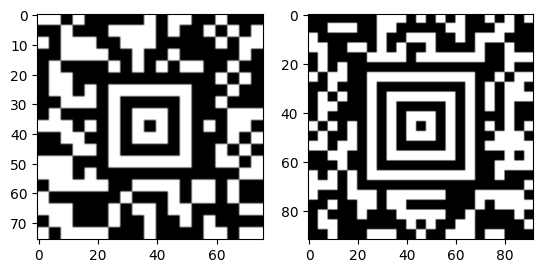

1


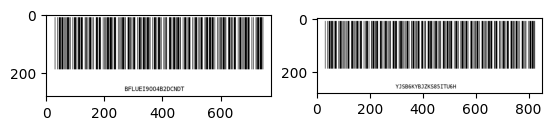

2


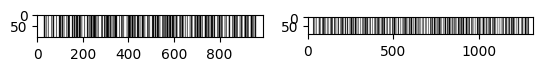

3


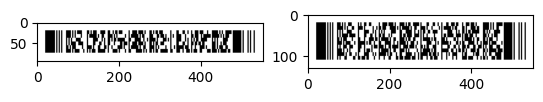

4


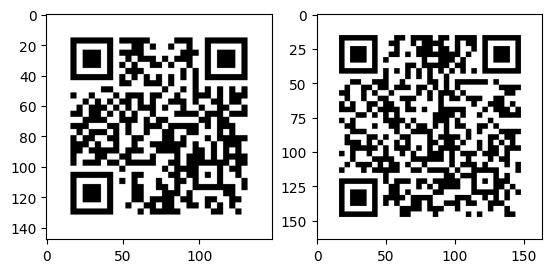

5


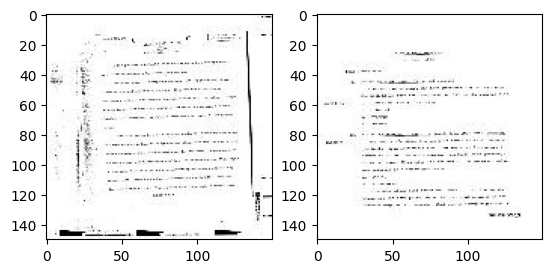

In [73]:
for label in sorted(list(set(y))):
    print(label)
    plt.subplot(121)
    plt.imshow(X_imgs[y == label][0], cmap='gray')
    plt.subplot(122)
    plt.imshow(X_imgs[y == label][100], cmap='gray')
    plt.show()

## Let us try simpliest feature -- ratio of white color on the image.

In [74]:
def get_features(X_imgs):
    X = np.zeros((len(X_imgs), 1), dtype=np.float32)
    for i, img in enumerate(tqdm(X_imgs, desc="Extracting features...")):
        X[i, 0] = img.mean() / 255  # fast internal NumPy mean
    return X

In [75]:
X = get_features(X_imgs)

Extracting features...: 100%|██████████| 7000/7000 [00:01<00:00, 5463.06it/s] 


In [76]:
from sklearn.linear_model import LogisticRegression as LR

### Only training part of the dataset is labeled. So, it is the only part of the dataset we can use for training and testing.
### Let us try test on the same part we used for training (not a good idea, actually):

In [77]:
# Here we are training Logistic Regression:
model = LR()
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


#### Calculating the score:

In [78]:
model.score(X, y)

0.6725714285714286

#### Score above is accuracy score. We may calculate it manually by calculating ratio of correct classifications:

In [79]:
y_pred = model.predict(X)
print('Accuracy =', (y_pred == y).sum() / len(y))

Accuracy = 0.6725714285714286


## Let us review testing data and generate resulting file:

In [80]:
X_test_imgs = []
test_names = []
for fn in tqdm(glob('data/barcodes/test/*'), desc='Reading test set'):
    X_test_imgs.append(cv2.imread(fn, cv2.IMREAD_GRAYSCALE))
    test_names.append(os.path.basename(fn))
X_test_imgs = np.array(X_test_imgs, dtype="object")

Reading test set:   0%|          | 0/1750 [00:00<?, ?it/s]

Reading test set: 100%|██████████| 1750/1750 [00:21<00:00, 79.74it/s]


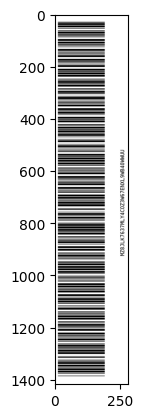

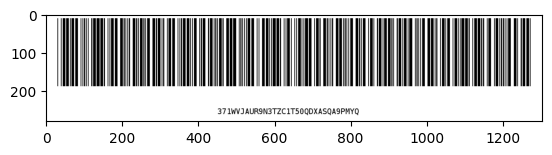

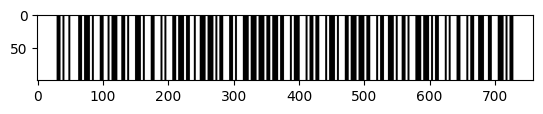

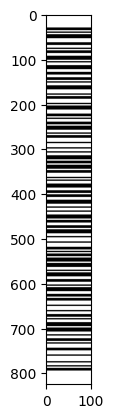

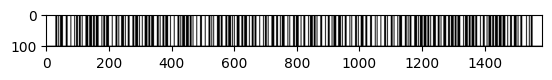

In [81]:
for im in X_test_imgs[:5]:
    plt.imshow(im, cmap='gray')
    plt.show()

## As you may see, images in the dataset can be rotated. You should be able to deal with it.

## Let us generate the answer:

In [82]:
X_test = get_features(X_test_imgs)

Extracting features...: 100%|██████████| 1750/1750 [00:00<00:00, 5533.13it/s]


In [83]:
y_test_pred = model.predict(X_test)

0


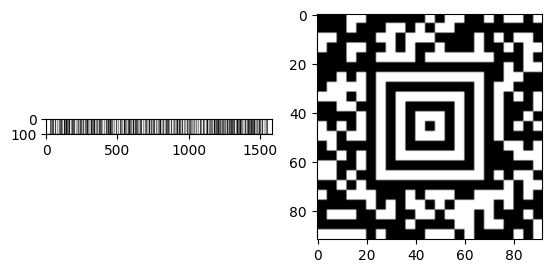

1


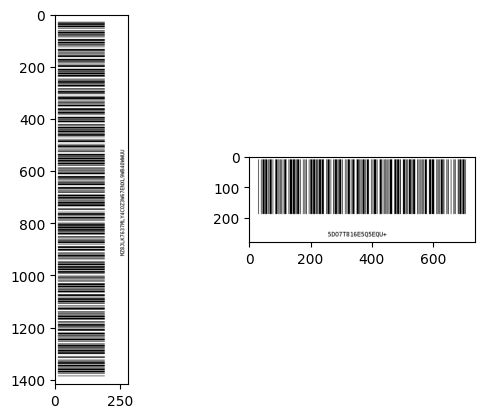

2


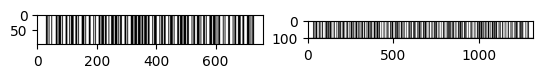

3
4
5


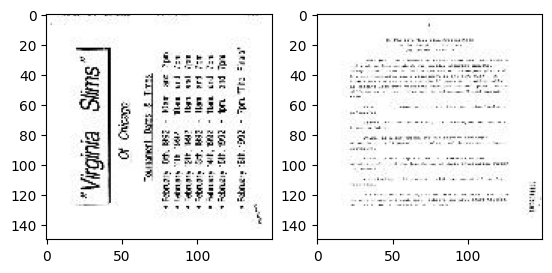

In [84]:
for label in sorted(list(set(y))):
    print(label)
    if (y_test_pred == label).sum() < 6:
        continue
    plt.subplot(121)
    plt.imshow(X_test_imgs[y_test_pred == label][0], cmap='gray')
    plt.subplot(122)
    plt.imshow(X_test_imgs[y_test_pred == label][5], cmap='gray')
    plt.show() 

# Your task is to:
- Find better way to evaluate your model (not to make testing on training set).
- Get higher accuracy (>95% -- 1 point, >97% -- 2 points, >98% -- 3 points, >99% -- 4 points, >99.5% -- 5 pointis).
- Plot confusion matrix for your model (1 point) and ROC curves for each class (1 point).

In [85]:
# store matrix and ROC curves as images here:
conf_matrix = None
ROC_curves = []

In [86]:
answer_to_submit = {fn: yy for fn, yy in zip(test_names, y_test_pred)}

In [87]:
with open('my_answer.pkl', 'wb') as f:
    pkl.dump((answer_to_submit, conf_matrix, ROC_curves, uuid.uuid4().hex, time()), f)

### Now submit `my_answer.pkl` (either to google classroom or to yandex contest, I will let you know the proper way after the weekend).

My code starts from here

In [88]:
def count_components(img, threshold=128, small_max=10, big_min=20):
    _, mask = cv2.threshold(img, threshold, 1, cv2.THRESH_BINARY_INV)
    n_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    widths = stats[1:, cv2.CC_STAT_WIDTH]
    heights = stats[1:, cv2.CC_STAT_HEIGHT]

    small_count = np.sum((widths <= small_max) & (heights <= small_max))
    big_count = np.sum((widths >= big_min) & (heights >= big_min))
    return int(small_count), int(big_count)

In [89]:
def extract_feature(img, small_max=10, big_min=20, threshold=128):
    # this could have be done once before, preprocess
    _, img_bin = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)   
    img_bin = img

    height, width = img.shape
    aspect_ratio = height / width

    small_components, big_components = count_components(img_bin, small_max, big_min)

    return [
        small_components,
        big_components,
        aspect_ratio,
        height
    ]

In [90]:
import numpy as np

def rotate(img, angle):
    """
    Rotate a 2D image by 0, 90, 180, or 270 degrees clockwise.
    """
    if angle == 0:
        return img.copy()
    elif angle == 90:
        return np.rot90(img, k=-1)  # clockwise
    elif angle == 180:
        return np.rot90(img, k=2)
    elif angle == 270:
        return np.rot90(img, k=1)   # counterclockwise
    else:
        raise ValueError("Angle must be 0, 90, 180, or 270")


In [91]:
angles = [0, 90, 180, 270]

X_imgs_aug = []
y_aug = []

for img, label in tqdm(zip(X_imgs, y), total=len(X_imgs), desc="Augmenting images..."):
    for angle in angles:
        X_imgs_aug.append(rotate(img, angle))
        y_aug.append(label)


Augmenting images...: 100%|██████████| 7000/7000 [00:01<00:00, 6086.29it/s] 


In [92]:
X_array = []

for img in tqdm(X_imgs_aug, desc="Extracting features..."):
    features = extract_feature(img)
    X_array.append(features)

X_array = np.array(X_array)

Extracting features...: 100%|██████████| 28000/28000 [00:30<00:00, 924.67it/s] 


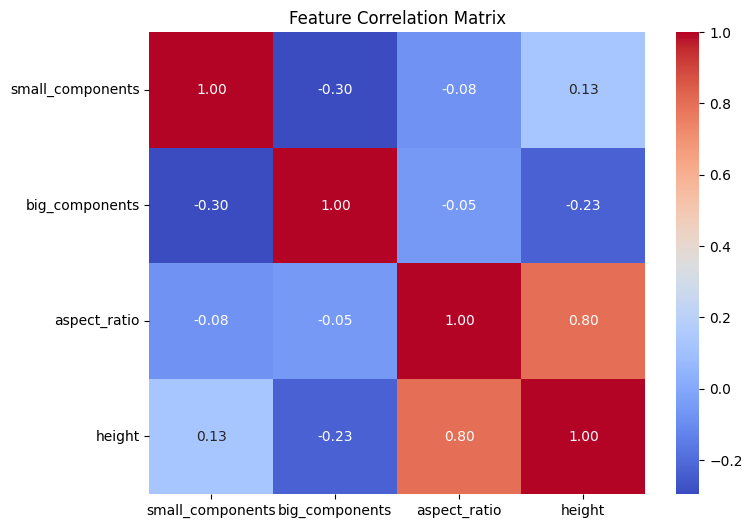

In [93]:
import seaborn as sns
import pandas as pd

feature_names = [
    'small_components',
    'big_components',
    'aspect_ratio',
    'height'
]
df_features = pd.DataFrame(X_array, columns=feature_names)

# Compute correlation matrix
corr_matrix = df_features.corr()

# Print
# print(corr_matrix)

# Optional: nicer plot using seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),     # Step 1: scale features
    # ('clf', LogisticRegression())     # Step 2: classifier
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipeline.fit(X_array, y_aug)
print(f"Cross-validation score: {cross_val_score(pipeline, X_array, y_aug, cv=5)}")
print(f"Accuracy: {pipeline.score(X_array, y_aug)}")

Cross-validation score: [1.         0.99928571 0.99928571 1.         1.        ]
Accuracy: 1.0


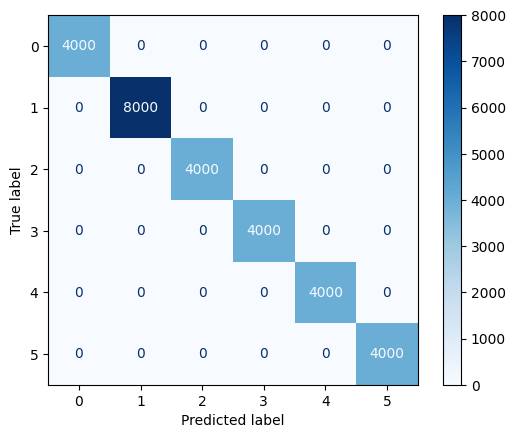

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = pipeline.predict(X_array)

cm = confusion_matrix(y_aug, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


ROC AUC (macro, one-vs-one): 1.0


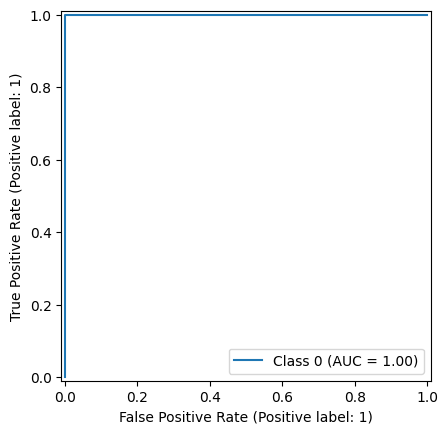

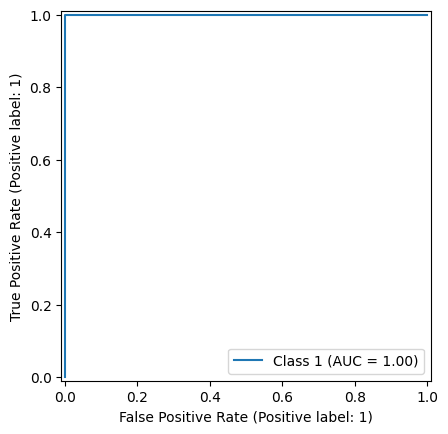

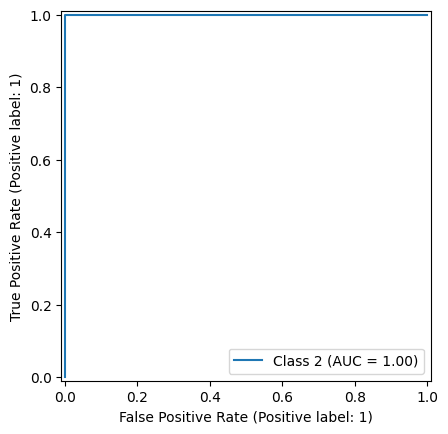

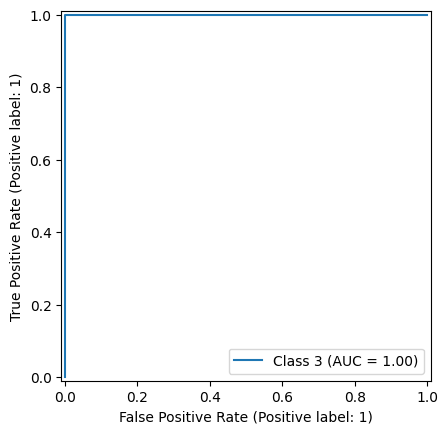

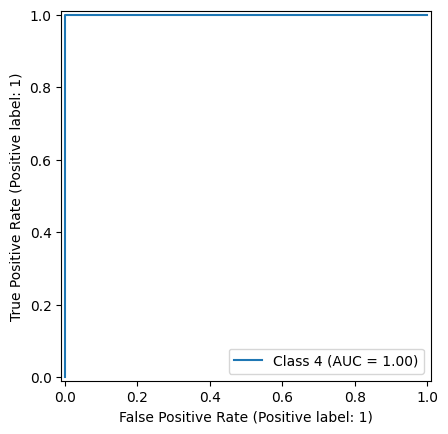

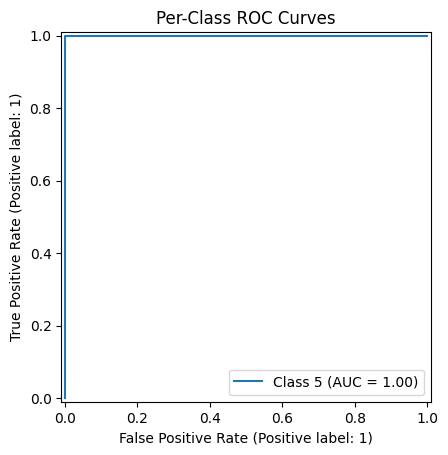

In [96]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

classes = np.unique(y_aug)
y_bin = label_binarize(y_aug, classes=classes)  # shape: (n_samples, 5)
y_pred_proba = pipeline.predict_proba(X_array)  # shape: (n_samples, 5)
auc = roc_auc_score(y_bin, y_pred_proba, multi_class='ovo', average='macro')
print("ROC AUC (macro, one-vs-one):", auc)
for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_bin[:, i],
        y_pred_proba[:, i],
        name=f"Class {cls}"
    )

plt.title("Per-Class ROC Curves")
plt.show()

In [97]:
X_test_array = []
for img in tqdm(X_test_imgs, desc="Extracting features..."):
    features = extract_feature(img)
    X_test_array.append(features)

X_test_array = np.array(X_test_array)

Extracting features...: 100%|██████████| 1750/1750 [00:01<00:00, 1007.69it/s]


In [98]:
y_test_pred = pipeline.predict(X_test_array)
answer_to_submit = {fn: yy for fn, yy in zip(test_names, y_test_pred)}

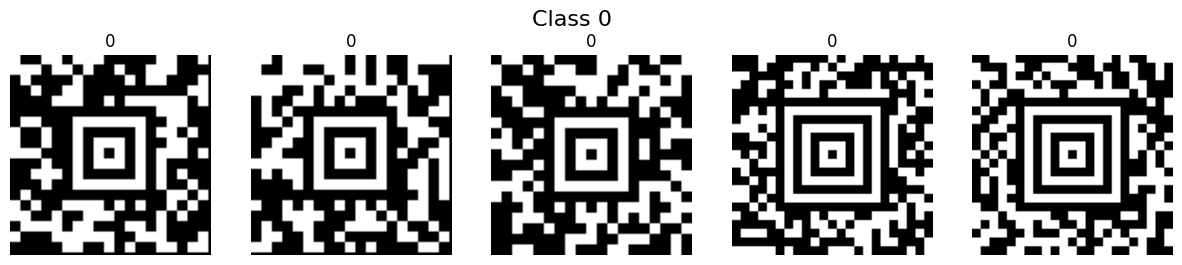

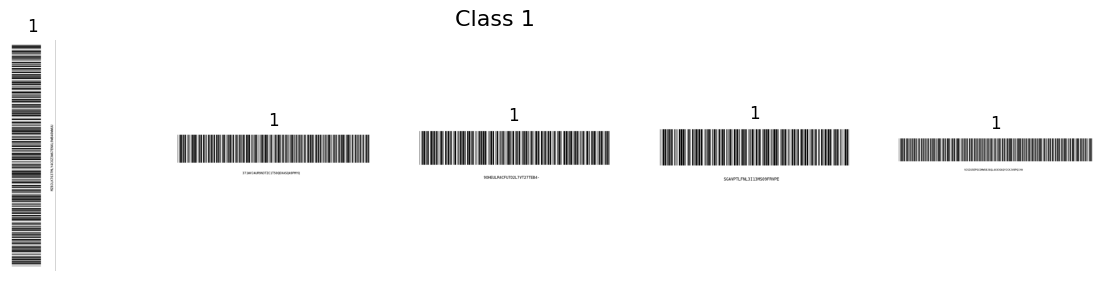

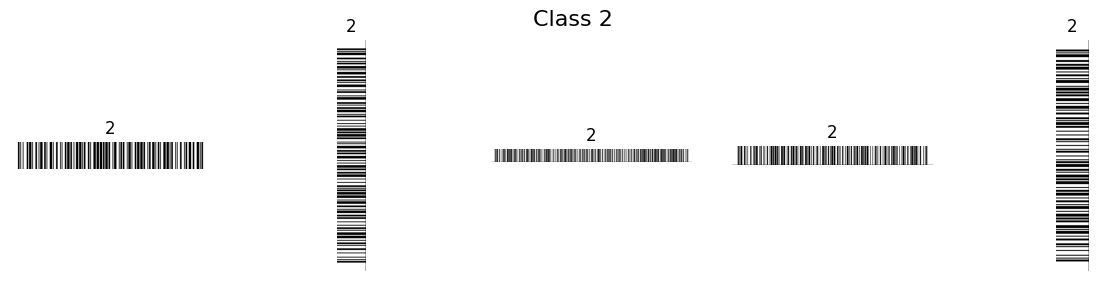

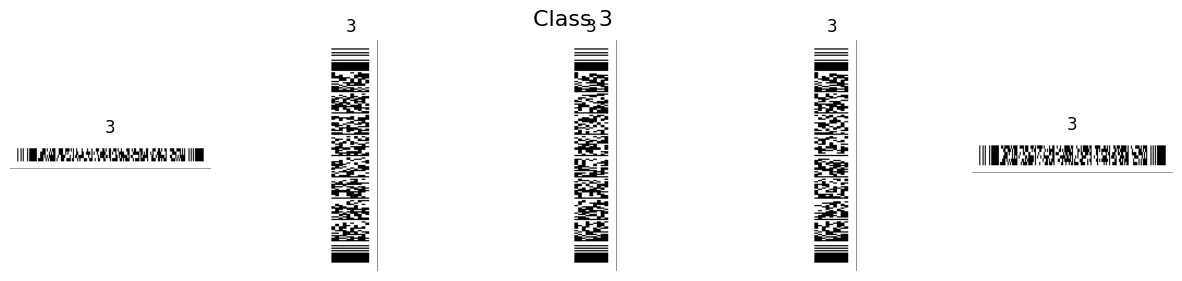

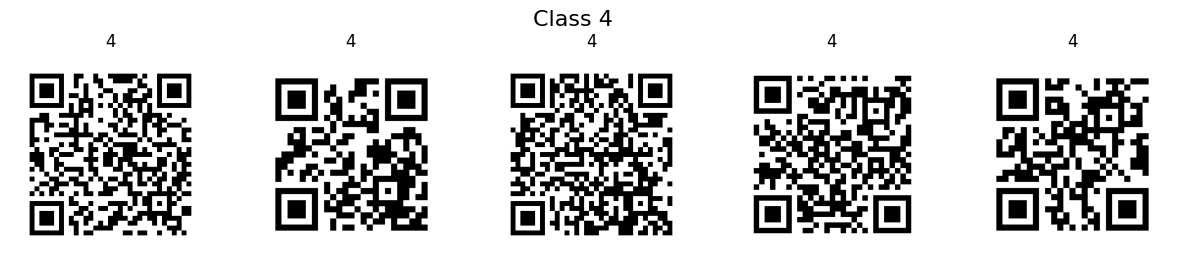

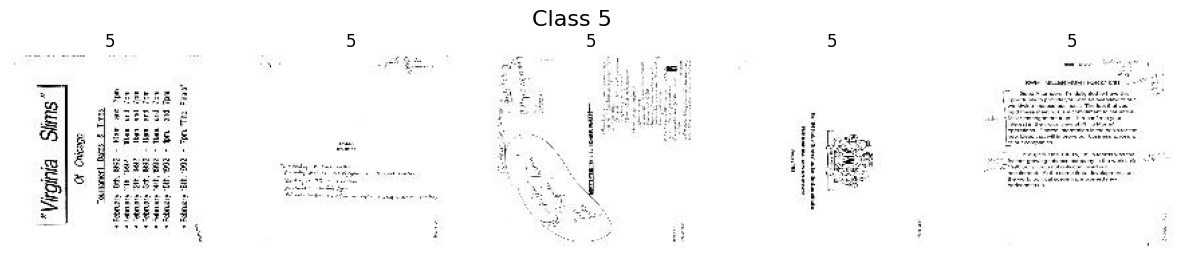

In [99]:
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

grouped = defaultdict(list)
for img, label in zip(X_test_imgs, y_test_pred):
    grouped[label].append(img)

for label in range(6):
    imgs = grouped[label]
    n = len(imgs)
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Class {label}", fontsize=16)
    
    for i, img in enumerate(imgs[:5]):  # show up to 5 images per class
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"{label}")
    
    plt.show()


In [100]:
with open('my_answer_cesar.pkl', 'wb') as f:
    pkl.dump((answer_to_submit, cm, auc, uuid.uuid4().hex, time()), f)